In [125]:
import rawpy
import imageio
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
from torchvision import models
from matplotlib import pyplot as plt
import torch
from torchsummary import summary
from collections import defaultdict
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch
import torch.nn as nn
# from loss import dice_loss
from tqdm import tqdm
import random
import pickle
from torch.utils.tensorboard import SummaryWriter

In [2]:
with open('/home/ad/dng/raw_list.pkl','rb') as f:
    raw_list = pickle.load(f)
    raw_array = np.stack(raw_list)
    del raw_list
    raw_array[raw_array>255] = 255
    raw_array = raw_array.astype(np.float32)/255.0
with open('/home/ad/dng/rgb_list.pkl','rb') as f:
    rgb_list = pickle.load(f)
    rgb_array = np.stack(rgb_list)
    del rgb_list
    rgb_array = rgb_array.astype(np.float32)/255.0

In [52]:
class SimDataset(Dataset):
    def __init__(self, raw_array, rgb_array,count, transform=None):
        # self.flist = []
        self.size = 32
        self.stride = 2
        self.count = count
        self.raw_array = raw_array
        self.rgb_array = rgb_array
        # for x in tqdm(path.iterdir()):
        #     if x.is_file():
        #         self.flist.append(x)
        #         raw = rawpy.imread(str(x))
        #         self.raw_list.append(raw.raw_image)
        #         self.rgb_list.append(raw.postprocess())

#         self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
        self.source_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.479], [0.212]) # dng
        ])
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
        ])
    def __len__(self):
        return self.count
    
    def __getitem__(self, idx):  
        stride = self.stride
        sample_num = idx%len(self.raw_array)
#         raw = rawpy.imread(str(self.flist[idx]))
        raw_image = self.raw_array[sample_num]
        rgb = self.rgb_array[sample_num]
        x = random.randint(0,int((raw_image.shape[0]-train_set.size-1)/stride))
        y = random.randint(0,int((raw_image.shape[1]-train_set.size-1)/stride))
        raw_crop = raw_image[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
        rgb_crop = rgb[stride*x:stride*x+self.size,stride*y:stride*y+self.size]
#         if self.transform:
#             raw_image = self.transform(raw_image.astype(np.float32))
#             rgb = self.transform(rgb)
        return [self.source_transform(raw_crop), self.target_transform(rgb_crop)]


In [53]:
directory = Path('/content/intern_task')
train_set = SimDataset(raw_array[2:],rgb_array[2:], 512)
val_set = SimDataset(raw_array[:2],rgb_array[:2], 64)

In [54]:
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2);
val_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=2);

In [6]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


In [7]:
inv_tensor = inv_normalize(train_set[0][1])#.numpy().astype(np.uint8).

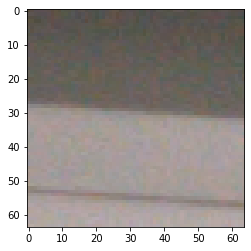

In [8]:
plt.imshow(inv_tensor.permute(1,2,0))

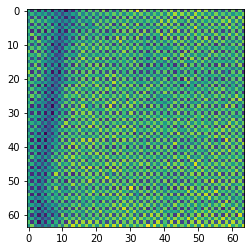

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


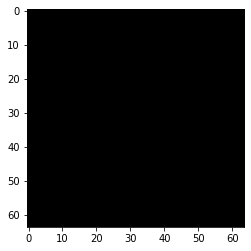

In [9]:
raw, rgb = train_set[0]
plt.imshow(raw.permute(1,2,0))
plt.show()
plt.imshow(rgb.permute(1,2,0))
plt.show()

In [10]:
plt.imshow(reverse_transform(rgb))

NameError: name 'reverse_transform' is not defined

In [119]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
      
        self.layer0 = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
          nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
          nn.ReLU(inplace=True)
        )
        self.layer1 =         nn.Sequential(
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
          nn.Sequential(
            nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
              nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.ReLU(inplace=True),
              nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
              nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            ),
            nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
              nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
              nn.ReLU(inplace=True),
              nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
              nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            )
          )
        )
        self.layer0_1x1 = convrelu(32, 32, 1, 0)
   
        self.layer1_1x1 = convrelu(32, 32, 1, 0)       
        self.layer2 = nn.Sequential(
          nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sequential(
              nn.Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False),
              nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            )
          ),
          nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        self.layer2_1x1 = convrelu(128, 32, 1, 0)  
        self.mp1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up1 = convrelu(64, 64, 3, 1)
        self.conv_up0 = convrelu(32 + 64, 64, 3, 1)
        
        self.conv_original_size0 = convrelu(1, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 64, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)   
        
        layer1 = self.layer1(layer0)

        layer2 = self.layer2(layer1)
 
        layer2 = self.layer2_1x1(layer2)
        x = self.upsample(layer2)
        layer1 = self.layer1_1x1(x)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)
        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out



In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(3)
model = model.to(device)

# summary(model, input_size=(3, 224, 224))

In [121]:
inputs, labels = next(iter(train_dataloader))
out = model(inputs.to(device))

In [122]:
summary(model,input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]             288
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
        MaxPool2d-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

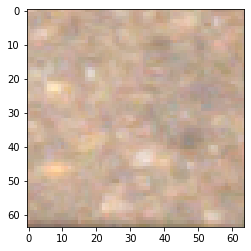

In [16]:
plt.imshow(inv_normalize(labels[0]).permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


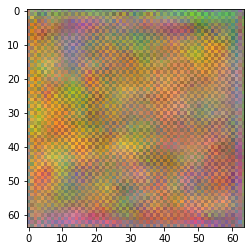

In [17]:
plt.imshow(inv_normalize(out.detach().cpu()[0]).permute(1,2,0))

In [ ]:
model = torch.load('resnet18.pt')

In [123]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = ResNetUNet(num_class).to(device)
# model = torch.load('resnet18.pt')
# freeze backbone layers
# Comment out to finetune further
# for l in model.base_layers:
#     for param in l.parameters():
#         param.requires_grad = False

# optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# optimizer = optim.Adam(model.parameters(),lr=1e-4)
optimizer = optim.AdamW(model.parameters(),lr=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8) 


cuda:0


In [ ]:
num_epochs = 200
writer = SummaryWriter()
mse_loss = nn.MSELoss()

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))


    model.train()
    scheduler.step()
    for param_group in optimizer.param_groups:
        print("LR", param_group['lr'])

    losses = []
    progress = tqdm(train_dataloader)
    for inputs, labels in progress:
        inputs = inputs.to(device)
        labels = labels.to(device)             

        outputs = model(inputs)

        loss = mse_loss(outputs,labels)
        losses.append(loss)

        # Backpropagation
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        progress.set_description(str(loss.item()))

    writer.add_scalar('loss train', sum(losses)/len(losses), epoch)
    writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)

    losses = []
    model.eval()
    progress = tqdm(val_dataloader)
    for inputs, labels in progress:
        inputs = inputs.to(device)
        labels = labels.to(device)             

        # forward
        # track history if only in train

        
        with torch.no_grad():
            outputs = model(inputs)
            loss = mse_loss(outputs,labels)
        losses.append(loss)

        progress.set_description(str(loss.item()))

    writer.add_scalar('loss val', sum(losses)/len(losses), epoch)


    print("loss:", sum(losses)/len(losses))
    print(optimizer.param_groups[0]['lr'])





In [ ]:
torch.save(model,'resnet18_64_3l.pt')

In [ ]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

In [66]:
inp, label = next(iter(val_dataloader))

In [ ]:
mse_loss(out,labels.to(device))

In [ ]:
model.eval()

In [ ]:
reverse_transform(label.cpu())

In [ ]:
inp, label = train_set[0]
with torch.no_grad():
    out = model(inp.unsqueeze(0).to(device))    
    out_img = reverse_transform(out[0].cpu())
    label_img = reverse_transform(label.cpu())

In [81]:
%%time
with torch.no_grad():
    out = model(inp.to(device))

CPU times: user 10.7 ms, sys: 254 µs, total: 10.9 ms
Wall time: 8.07 ms


In [ ]:
plt.imshow(label_img)

In [ ]:
plt.imshow(reverse_transform(out[0].cpu().detach()))

In [ ]:
plt.imshow(reverse_transform(label))

In [ ]:
plt.imshow(out[0].cpu().permute(1,2,0).detach().numpy())

In [ ]:
label.shape

In [ ]:
plt.imshow(label_img)

In [ ]:
plt.imshow(out_img)